In [1]:
import random
import itertools
import networkx as nx

In [2]:
import networkx as nx
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

In [4]:
# import for log the data
import hashlib
from datetime import datetime

# Process Graph

## Parameters

In [5]:
subset_sizes = [1, 4, 2, 1]
subset_color = [
    "gold",
    "violet",
    "limegreen",
    "darkorange"
]

In [6]:
edges=[
    (0, 1), (0, 2), (0, 3), (0, 4),
    
    (1, 5), (2, 5),
    (3, 6), (4, 6),

    (5, 7), (6, 7)
]

In [7]:
node_durations = {
    0 : {
        "duration": 5,
    },
    1 : {   
        "duration": 2,
    },
    2 : {
        "duration": 2,
    },
    3 : {
        "duration": 2,
    },
    4 : {
        "duration": 2,
    },
    5 : {
        "duration": 4,
    },
    6 : {
        "duration": 3,
    },
    7 : {
        "duration": 7,
    }
}

## Functions

In [8]:
def multilayered_graph(*subset_sizes:list[int], edges:list[tuple]=None) -> nx.DiGraph:
    """
    Create a multilayered graph with the given subset sizes and edges. If edges is None, all possible edges connection between layers are created.
    
    Args:
        subset_sizes (list[int]): The number of nodes in each layer.
        edges (list[tuple]): A list of edges between layers. If None, all possible edges are created.

    Returns:
        nx.DiGraph: A multilayered graph.
    """
    extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
    layers = [range(start, end) for start, end in extents]
    G = nx.DiGraph()
    for i, layer in enumerate(layers):
        G.add_nodes_from(layer, layer=i)

    if edges is None:
        for layer1, layer2 in nx.utils.pairwise(layers):
            G.add_edges_from(itertools.product(layer1, layer2))
    else:
        G.add_edges_from(edges)

    return G

In [9]:
def allocate_node_durations(G:nx.DiGraph, node_durations:dict) -> nx.DiGraph:
    """
    Allocate the duration of each node in the graph.

    Args:
        G (nx.DiGraph): The graph to allocate the durations to.
        node_durations (dict): A dictionary of node durations.
    
    Returns:
        nx.DiGraph: The graph with the durations allocated
    """
    for node, data in node_durations.items():
        G.nodes[node]["duration"] = data["duration"]
    return G

## Graph

In [10]:
G = multilayered_graph(*subset_sizes, edges=edges)
G.edges

OutEdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (1, 5), (2, 5), (3, 6), (4, 6), (5, 7), (6, 7)])

In [11]:
G = allocate_node_durations(G, node_durations)
G.nodes.data()

NodeDataView({0: {'layer': 0, 'duration': 5}, 1: {'layer': 1, 'duration': 2}, 2: {'layer': 1, 'duration': 2}, 3: {'layer': 1, 'duration': 2}, 4: {'layer': 1, 'duration': 2}, 5: {'layer': 2, 'duration': 4}, 6: {'layer': 2, 'duration': 3}, 7: {'layer': 3, 'duration': 7}})

## Visualization

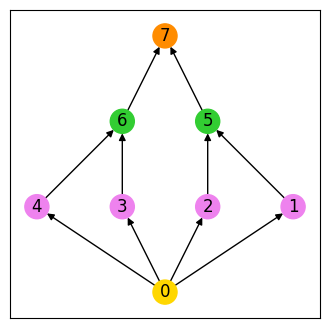

In [12]:
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer", align='horizontal')
plt.figure(figsize=(4,4))
nx.draw_networkx(G, pos, node_color=color)
# nx.draw_networkx_edge_labels(
#     G, pos, edge_labels={(u, v): d["weight"] for u, v, d in G.edges(data=True)}
# )
plt.axis("equal")
plt.show()

# Classes

In [13]:
class Task:
    """
    Represents a task with a name, priority, and duration.

    Attributes:
        name (str): The name of the task.
        duration (int): The duration of the task in minutes.
        priority (int): The priority of the task. Lower numbers indicate higher priority.
    """

    def __init__(self, name:str, duration:int, priority:int=0) -> None:
        """
        Initializes a new Task instance.

        Args:
            name (str): The name of the task.
            duration (int): The duration of the task in minutes.
            priority (int): The priority of the task.
        """
        self.name = name
        self.priority = priority
        self.duration = duration
        self.status = False # False = not started, True = completed
        self.dependencies = [Task]
        self.enable = False # False = not enabled, True = enabled
        self.processed_by:str = None

        self.start_time = 0
        self.end_time = self.start_time + self.duration

    def check_status(self) -> bool:
        """
        Checks the status of the task.
        False = not started;
        True = completed;

        Returns:
            bool: The status of the task.
        """
        return self.status

    def start_task(self, start_time:int) -> None:
        """
        Starts the task.

        Args:
            start_time (int): The start time of the task.
        """
        self.start_time = start_time

    def end_task(self) -> None:
        """
        Ends the task.

        Args:
            end_time (int): The end time of the task.
        """
        self.end_time = self.start_time + self.duration

    def task_data(self) -> dict:
        """
        Returns the task data.

        Returns:
            dict: The task data.
        """
        return {
            "name": str(self.name),
            "duration": self.duration,
            "priority": self.priority,
            "status": self.status,
            "dependencies": self.dependencies,
            "enable": self.enable,
            "processed_by": self.processed_by,
            "start_time": self.start_time,
            "end_time": self.end_time
        }

    def __repr__(self):
        """
        Returns a string representation of the Task instance.

        Returns:
            str: A string representation of the Task instance.
        """
        return f"Task(name={self.name}, duration={self.duration})"

In [14]:
class Processor:
    """
    Represents a processor that executes tasks.

    Attributes:
        name (str): The name of the processor.
    """

    def __init__(self, name: str):
        """
        Initializes a new Processor instance.

        Args:
            name (str): The name of the processor.
        """
        self.name = name

        self.task:Task = None
        self.active = False
        self.status = "idle"

    def check_status(self):
        """
        Checks the status of the processor.

        Returns:
            str: The status of the processor.
        """
        return self.status

    def activate(self):
        """
        Activates the processor.
        """
        self.active = True
        self.status = "busy"

    def deactivate(self):
        """
        Deactivates the processor.
        """
        self.active = False
        self.status = "idle"
        self.task = None
    
    def __repr__(self):
        """
        Returns a string representation of the Processor instance.

        Returns:
            str: A string representation of the Processor instance.
        """
        return f"Processor(name={self.name}, Satus={self.status}, Task={self.task})"

In [15]:
class Scheduler:
    """
    Manages a list of tasks, allowing tasks to be added, removed, and executed based on priority.

    Attributes:
        tasks (list): A list of Task instances.
    """

    def __init__(self, graph:nx.DiGraph):
        """
        Initializes a new Scheduler instance with an empty task list.

        Attributes:
            tasks (list): A list of Task instances.
        """
        self.graph = graph
        self.tasks:list[Task] = []
        self.processor:list[Processor] = [] #, p2 := Processor("P2")]

        self.time = 0
        self.pending_tasks:list[Task] = [] # list of tasks that can be executed
        self.completed_tasks:list[Task] = [] # list of tasks that have been completed

    def get_task(self, name:str) -> Task:
        """
        Get a task by name.

        Args:
            name (str): The name of the task to get.

        Returns:
            Task: The task instance.
        """
        return next((task for task in self.tasks if task.name == name), None)

    def check_pending_tasks(self, name:str) -> bool:
        """
        Check if a task is in the pending tasks list.

        Args:
            name (str): The name of the task to check.

        Returns:
            bool: True if the task is in the pending tasks list; False otherwise.
        """
        return any(task.name == name for task in self.pending_tasks)

    def get_task_dependencies(self, task:Task) -> list[Task]:
        """
        Get the dependencies of a task.

        Args:
            task (Task): The task to get the dependencies of.

        Returns:
            list: The list of dependencies.
        """
        return [self.get_task(name) for name in self.graph.predecessors(task.name)]
        # return list(self.graph.predecessors(task.name))

    def get_free_processor(self) -> Processor:
        """
        Get a free processor.

        Returns:
            Processor: The free processor.
        """
        for p in self.processor:
            if not p.active:
                return p
        return None

    def add_task(self, task:Task):
        """
        Adds a new task to the scheduler and sorts the tasks by priority.

        Args:
            task (Task): The Task instance to add.
        """
        self.tasks.append(task)
        self.tasks.sort(key=lambda x: x.name)

    def remove_pending_tasks(self, task:Task):
        """
        Removes a task from the scheduler.

        Args:
            task (Task): The Task instance to remove.
        """
        self.pending_tasks.remove(task)

    def generate_tasks(self):
        """
        Generates tasks from a directed graph.

        Args:
            graph (nx.DiGraph): A directed graph representing the tasks.
        """
        self.tasks = []
        for node in self.graph.nodes:
            task = Task(node, self.graph.nodes[node]['duration'])
            task.dependencies = self.get_task_dependencies(task)
            self.add_task(task)
            if len(task.dependencies) == 0:
                task.enable = True
                self.pending_tasks.append(task)

    def generate_processors(self, quantity:int):
        """
        Generates a quantity of processors.

        Args:
            quantity (int): The quantity of processors to generate.
        """
        self.processor = []
        for i in range(quantity):
            processor = Processor(f"P{i}")
            self.processor.append(processor)

    def allocate_task_processor(self):
        """
        Allocates a enabled tasks to a processor if there any of both available.
        """
        if len(self.pending_tasks) == 0:
            return

        task = random.choice(self.pending_tasks)

        if not task.status:
            processor = self.get_free_processor()
            if processor:
                processor.task = task
                processor.activate()
                task.start_task(self.time)
                task.end_task()
                task.processed_by = processor.name
                self.remove_pending_tasks(task)

    def pre_allocation(self, allocation:dict):
        """
        Pre-allocate tasks to processors.

        Args:
            allocation (dict): A dictionary of tasks allocated to processors.
        """

        for task_name, processor_name in allocation.items():
            task = self.get_task(task_name)
            processor = next((p for p in self.processor if p.name == processor_name), None)
            if (not processor.active) and self.check_pending_tasks(task_name):
                processor.task = task
                processor.activate()
                task.start_task(self.time)
                task.end_task()
                task.processed_by = processor.name
                self.remove_pending_tasks(task)

    def complete_tasks(self):
        """
        Completes tasks that have reached their end time. Foe each processor, check if the task has been completed.
        """
        for processor in self.processor:
            # print(f"Processor: {processor.name}")
            if processor.task and self.time >= processor.task.end_time:
                # print(f"Task: {processor.task.name} completed")
                self.completed_tasks.append(processor.task)
                processor.task.status = True
                processor.deactivate()

    def enable_task(self):
        """
        Verify tasks that have all dependencies completed and enable them.
        """
        for task in self.tasks:
            if not task.status and not task.enable:
                dependencies = [dep.status for dep in task.dependencies]
                if all(dependencies):
                    task.enable = True
                    self.pending_tasks.append(task)

    def create_allocation(self, grid:np.ndarray=None) -> dict:
        """
        Create a random allocation of tasks to processors. If a grid is provided, the allocation is based on the grid. Otherwise, the allocation is random.

        Args:
            grid (np.ndarray): A grid of tasks allocated to processors.

        Returns:
            dict: A dictionary of tasks allocated to processors.

        Example:
            {
                "0": "P0",
                "1": "P0",
                "2": "P1",
                "3": "P0",
                "4": "P2"
            }
        
            grid = np.array([ 0, 0, 1, 0, 2])
        """
        allocation = {}
        if grid is not None:
            for i, processor in enumerate(grid):
                task = i
                processor = f"P{processor}"
                allocation[task] = processor
        else:
            for task in self.tasks:
                allocation[task.name] = random.choice(self.processor).name
        return allocation

    def run(self, grid:np.ndarray=None):
        """
        Runs the scheduler.
        """
        self.generate_processors(2)
        self.generate_tasks()
        while len(self.completed_tasks) < len(self.tasks):
            # print(f"Time: {self.time}")
            # print(f"Enable tasks: {[task.name for task in self.pending_tasks]}")
            # print(f"Completed tasks: {[task.name for task in self.completed_tasks]}")
            # print(f"Tasks: {[task.name for task in self.tasks]}")
            # print(f"Time: {self.time}")
            # print(f"Enable tasks: {[task.name for task in self.enable_tasks]}")
            # print(f"Completed tasks: {[task.name for task in self.completed_tasks]}")
            # print(f"Tasks: {[task.name for task in self.tasks]}")
            # print(f"Processors: {[processor for processor in self.processor]}")
            
            if grid is not None:
                allocation = self.create_allocation(grid)
                self.pre_allocation(allocation)
            else:
                for _ in range(len(self.processor)):
                    self.allocate_task_processor()

            self.complete_tasks()
            self.time += 1

            self.enable_task()

            if self.time > 100:
                break

In [16]:
class CellularAutomata:
    """
    Represents a 1D cellular automata with a given array size and number of timesteps.

    Attributes:
        array_size (int): The size of the 1D array.
        timesteps (int): The number of timesteps to run the automata.
        grid (np.array): The 1D array representing the cellular automata.
    """
    def __init__(self, timesteps:int, array_size:int=8, grid:np.ndarray=None) -> None:
        """
        Initializes a new CellularAutomata instance.

        Args:
            timesteps (int): The number of timesteps to run the automata.
            array_size (int): The size of the 1D array.
        """
        self.timesteps = timesteps
        self.array_size = array_size

        self.grid = grid
        self.history:np.ndarray

    def initialize_grid(self) -> np.ndarray:
        """
        Initializes the grid with random 0s and 1s.

        Returns:
            np.ndarray: The initialized grid.
        """
        # Initialize the grid with random 0s and 1s
        self.grid = np.random.randint(2, size=self.array_size) if self.grid is None else self.grid
        self.history = self.grid
        return self.grid

    def update_grid(self) -> None:
        """
        Updates the grid based on the given rules.

        Returns:
            None
        """
        # Placeholder for the update logic
        new_grid = self.grid.copy()
        for i in range(1, self.array_size - 1):
            # Example rule: new state is the XOR of the two neighbors
            new_grid[i] = self.grid[i-1] ^ self.grid[i+1]
        self.grid = new_grid
        self.history = np.vstack((self.history, self.grid))

    def elementary_update_grid(self) -> None:
        """
        Updates the grid based on the given rules.

        Returns:
            None
        """
        # Initialize the new grid
        new_grid = self.grid.copy()
        
        # Iterate through each cell, excluding the boundary cells
        for i in range(1, self.array_size - 1):
            # Apply Rule 30: new state is determined by the current state and the state of two neighbors
            left = self.grid[i-1]
            center = self.grid[i]
            right = self.grid[i+1]
            
            # Rule 30 logic
            new_grid[i] = left ^ (center | right)
        
        # Update the grid
        self.grid = new_grid
        
        # Update the history
        self.history = np.vstack((self.history, self.grid))

    def run(self) -> None:
        """
        Runs the cellular automata for the given number of timesteps.
        
        Returns:
            None
        """
        self.grid = self.initialize_grid()
        for _ in range(self.timesteps):
            # self.update_grid()
            self.elementary_update_grid()

    def plot(self) -> None:
        """
        Plots the grid.

        Returns:
            None
        """
        plt.imshow(self.history, cmap='Greys', interpolation='nearest')
        plt.title("1D Cellular Automata")
        plt.xlabel("Cell Index")
        plt.ylabel("Timestep")
        plt.show()

# another referece for the cellular automata: https://github.com/lantunes/cellpylib

# Execution

## Alocation

In [33]:
grid = np.array([0, 0, 0, 1, 1, 1, 0, 0])
ca = CellularAutomata(timesteps=10, grid=grid)
ca.run()

## Simulation

In [34]:
sched = Scheduler(G)
allocation = sched.create_allocation(grid=ca.grid)
allocation

{0: 'P0', 1: 'P1', 2: 'P0', 3: 'P1', 4: 'P0', 5: 'P0', 6: 'P0', 7: 'P0'}

In [35]:
sched = Scheduler(G)
sched.run(grid=ca.grid)

## Struct Data

In [36]:
df = pd.DataFrame([task.task_data() for task in sched.tasks])
df

,name,duration,priority,status,dependencies,enable,processed_by,start_time,end_time
0,0,5,0,True,[],True,P0,0,5
1,1,2,0,True,"[Task(name=0, duration=5)]",True,P1,6,8
2,2,2,0,True,"[Task(name=0, duration=5)]",True,P0,6,8
3,3,2,0,True,"[Task(name=0, duration=5)]",True,P1,9,11
4,4,2,0,True,"[Task(name=0, duration=5)]",True,P0,9,11
5,5,4,0,True,"[Task(name=1, duration=2), Task(name=2, durati...",True,P0,12,16
6,6,3,0,True,"[Task(name=3, duration=2), Task(name=4, durati...",True,P0,17,20
7,7,7,0,True,"[Task(name=5, duration=4), Task(name=6, durati...",True,P0,21,28


In [37]:
df_gantt = df[['name', 'processed_by', 'start_time', 'duration', 'end_time']].copy()
df_gantt.rename(columns={'processed_by': 'processor', 'start_time': 'start', 'end_time': 'end'}, inplace=True)
def task_name(row):
    task_id = str(row["name"]).strip()
    return "Task " + task_id
df_gantt["name"] = df_gantt.apply(task_name, axis=1)
df_gantt

,name,processor,start,duration,end
0,Task 0,P0,0,5,5
1,Task 1,P1,6,2,8
2,Task 2,P0,6,2,8
3,Task 3,P1,9,2,11
4,Task 4,P0,9,2,11
5,Task 5,P0,12,4,16
6,Task 6,P0,17,3,20
7,Task 7,P0,21,7,28


In [38]:
# Data for the Gantt chart
tasks = df_gantt.to_dict('records')
tasks

[{'name': 'Task 0', 'processor': 'P0', 'start': 0, 'duration': 5, 'end': 5},
 {'name': 'Task 1', 'processor': 'P1', 'start': 6, 'duration': 2, 'end': 8},
 {'name': 'Task 2', 'processor': 'P0', 'start': 6, 'duration': 2, 'end': 8},
 {'name': 'Task 3', 'processor': 'P1', 'start': 9, 'duration': 2, 'end': 11},
 {'name': 'Task 4', 'processor': 'P0', 'start': 9, 'duration': 2, 'end': 11},
 {'name': 'Task 5', 'processor': 'P0', 'start': 12, 'duration': 4, 'end': 16},
 {'name': 'Task 6', 'processor': 'P0', 'start': 17, 'duration': 3, 'end': 20},
 {'name': 'Task 7', 'processor': 'P0', 'start': 21, 'duration': 7, 'end': 28}]

To make the grid not visible on the area of the barh, you can set the z-order of the bars to be higher than the grid lines. This way, the bars will be drawn on top of the grid lines.
In this code, the zorder parameter is used to control the drawing order. The grid lines are set with zorder=1, the bars with zorder=3, and the text labels with zorder=4. This ensures that the bars and text labels are drawn on top of the grid lines.

## Visualization

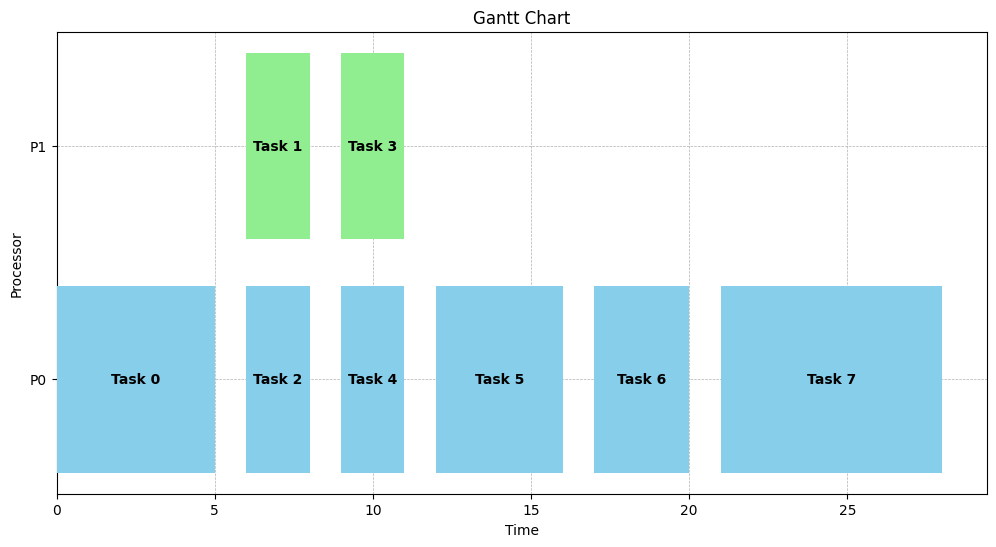

In [39]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create a color map for processors
colors = {'P0': 'skyblue', 'P1': 'lightgreen', 'P2': 'salmon'}

# Plot the Gantt chart
for idx, task in df_gantt.iterrows():
    ax.barh(task['processor'], task['duration'], left=task['start'], color=colors[task['processor']], zorder=3)

# Add task labels inside the bars
for idx, task in df_gantt.iterrows():
    ax.text(task['start'] + task['duration']/2, task['processor'], task['name'],
            va='center', ha='center', color='black', fontweight='bold', zorder=4)

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Processor')
ax.set_title('Gantt Chart')

# Set grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)

plt.show()

# LearingPhase

In [40]:
class LearningPhase:
    """
    A class to represent a learning phase. Run a Genetic Algorithm to learn the best allocation of tasks to processors.
    """
    def __init__(self,
                graph: nx.DiGraph,
                processor_quantity: int = 2,

                population_size: int = 10,
                mutation_rate: float = 0.1,
                crossover_rate: float = 0.8,
                elitism_rate: float = 0.1,
                max_generations: int = 100):
        """
        Initializes a new LearningPhase instance.

        Args:
            graph (nx.DiGraph): The directed graph representing the tasks and their dependencies.
            population_size (int): The size of the population in the genetic algorithm.
            mutation_rate (float): The probability of mutation in the genetic algorithm.
            crossover_rate (float): The probability of crossover in the genetic algorithm.
            elitism_rate (float): The percentage of the population to be preserved as elite individuals in the genetic algorithm.
            max_generations (int): The maximum number of generations in the genetic algorithm.
        """
        self.graph = graph
        self.processor_quantity = processor_quantity

        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism_rate = elitism_rate
        self.max_generations = max_generations

        self.best_hystory = []

    def initialize_population(self) -> list[np.ndarray]:
        """
        Initializes the population of individuals.

        Returns:
            list[np.ndarray]: The initial population of individuals.
        """
        population = []
        ca = CellularAutomata(timesteps=10, array_size=len(self.graph.nodes))
        for _ in range(self.population_size):
            ca.grid = None
            ca.run()            
            population.append(ca.grid)
        return population

    def evaluate_fitness(self, grid: np.ndarray) -> float:
        """
        Evaluates the fitness of an allocation.

        Args:
            grid (np.ndarray): A grid of tasks allocated to processors.

        Returns:
            float: The fitness value of the allocation.
        """
        sched = Scheduler(self.graph)
        sched.run(grid)
        return max([task.task_data()['end_time'] for task in sched.tasks])
        makespan = max([task.task_data()['end_time'] for task in sched.tasks])
        return 1 / makespan

    def select_parents(self, population: list[np.ndarray]) -> tuple[np.ndarray, np.ndarray]:
        """
        Selects two parents from the population using tournament selection.

        Args:
            population (list[np.ndarray]): The population of individuals.

        Returns:
            tuple[np.ndarray, np.ndarray]: The selected parents.
        """
        parent1 = random.choice(population)
        parent2 = random.choice(population)
        if self.evaluate_fitness(parent1) > self.evaluate_fitness(parent2):
            return parent1, parent2
        else:
            return parent2, parent1

    def crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> np.ndarray:
        """
        Performs crossover between two parents to produce a child.

        Args:
            parent1 (np.ndarray): The first parent.
            parent2 (np.ndarray): The second parent.

        Returns:
            np.ndarray: The child allocation.
        """
        child = []
        for task in parent1:
            if random.random() < self.crossover_rate:
                child.append(parent1[task])
            else:
                child.append(parent2[task])
        return np.array(child, dtype=int)

    def mutate(self, grid: np.ndarray) -> np.ndarray:
        """
        Performs mutation on an allocation.

        Args:
            grid (np.ndarray): A grid of tasks allocated to processors. The allocation to mutate.

        Returns:
            np.ndarray: The mutated allocation.
        """
        mutaded_grid = []
        for task in grid:
            if random.random() < self.mutation_rate:
                processors = set([p for p in range(self.processor_quantity)])
                processors.remove(task)
                p = random.choice(list(processors))
                mutaded_grid.append(p)
            else:
                mutaded_grid.append(task)
        return mutaded_grid

    def elitism_selection(self, population: list[np.ndarray]) -> list[np.ndarray]:
        """
        Performs elitism selection to preserve the best individuals in the population.

        Args:
            population (list[np.ndarray]): The population of individuals.

        Returns:
            list[np.ndarray]: The selected individuals.
        """
        population.sort(key=lambda x: self.evaluate_fitness(x), reverse=True)
        elite_size = int(self.elitism_rate * self.population_size)
        return population[:elite_size]

    def run_genetic_algorithm(self) -> np.ndarray:
        """
        Runs the genetic algorithm to find the best allocation of tasks to processors.

        Returns:
            dict[int, str]: The best allocation found.
        """
        population = self.initialize_population()
        for _ in range(self.max_generations):
            new_population = self.elitism_selection(population)
            while len(new_population) < self.population_size:
                parent1, parent2 = self.select_parents(population)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                new_population.append(child)
            population = new_population
            self.best_hystory.append(min(population, key=lambda x: self.evaluate_fitness(x)))
        best_allocation = min(population, key=lambda x: self.evaluate_fitness(x))
        return best_allocation

## Debug

In [41]:
lp = LearningPhase(G)
lp.initialize_population()

[array([0, 1, 0, 1, 0, 0, 0, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0]),
 array([0, 1, 0, 1, 0, 1, 0, 0]),
 array([0, 1, 0, 1, 1, 1, 1, 1]),
 array([0, 1, 0, 1, 0, 0, 1, 0]),
 array([0, 1, 0, 1, 1, 1, 1, 0]),
 array([1, 0, 1, 0, 0, 1, 0, 0]),
 array([0, 1, 0, 1, 0, 1, 0, 1]),
 array([0, 1, 0, 1, 0, 0, 0, 0]),
 array([1, 0, 1, 0, 1, 0, 0, 1])]

In [42]:
lp = LearningPhase(G)
lp.initialize_population()
lp.evaluate_fitness(lp.initialize_population()[0])

28

In [43]:
lp = LearningPhase(G)
lp.initialize_population()
lp.select_parents(lp.initialize_population())

(array([1, 0, 1, 0, 1, 0, 0, 0]), array([0, 1, 0, 1, 0, 1, 1, 0]))

In [44]:
lp = LearningPhase(G)
lp.initialize_population()
parent1, parent2 = lp.select_parents(lp.initialize_population())
lp.crossover(parent1, parent2)

array([0, 1, 1, 1, 1, 1, 1, 1])

In [45]:
lp = LearningPhase(G)
lp.mutate(np.array([0, 1, 1, 1, 1, 0, 1, 1]))

[0, 1, 1, 1, 1, 0, 1, 1]

In [46]:
lp = LearningPhase(G)
lp.initialize_population()
lp.elitism_selection(lp.initialize_population())

[array([1, 0, 1, 0, 1, 0, 0, 0])]

## Execution

In [47]:
lp = LearningPhase(G)
best = lp.run_genetic_algorithm()
print(lp.evaluate_fitness(best))
best

24


[0, 1, 0, 0, 1, 0, 1, 1]

In [48]:
best_hystory = min(lp.best_hystory, key=lambda x: lp.evaluate_fitness(x))
print(lp.evaluate_fitness(best_hystory))
best_hystory

24


[0, 1, 1, 0, 0, 1, 0, 0]

In [49]:
sched = Scheduler(G)
sched.run(grid=best_hystory)

In [50]:
df = pd.DataFrame([task.task_data() for task in sched.tasks])
df_gantt = df[['name', 'processed_by', 'start_time', 'duration', 'end_time']].copy()
df_gantt.rename(columns={'processed_by': 'processor', 'start_time': 'start', 'end_time': 'end'}, inplace=True)
def task_name(row):
    task_id = str(row["name"]).strip()
    return "Task " + task_id
df_gantt["name"] = df_gantt.apply(task_name, axis=1)
df_gantt

,name,processor,start,duration,end
0,Task 0,P0,0,5,5
1,Task 1,P1,6,2,8
2,Task 2,P1,9,2,11
3,Task 3,P0,6,2,8
4,Task 4,P0,9,2,11
5,Task 5,P1,12,4,16
6,Task 6,P0,12,3,15
7,Task 7,P0,17,7,24


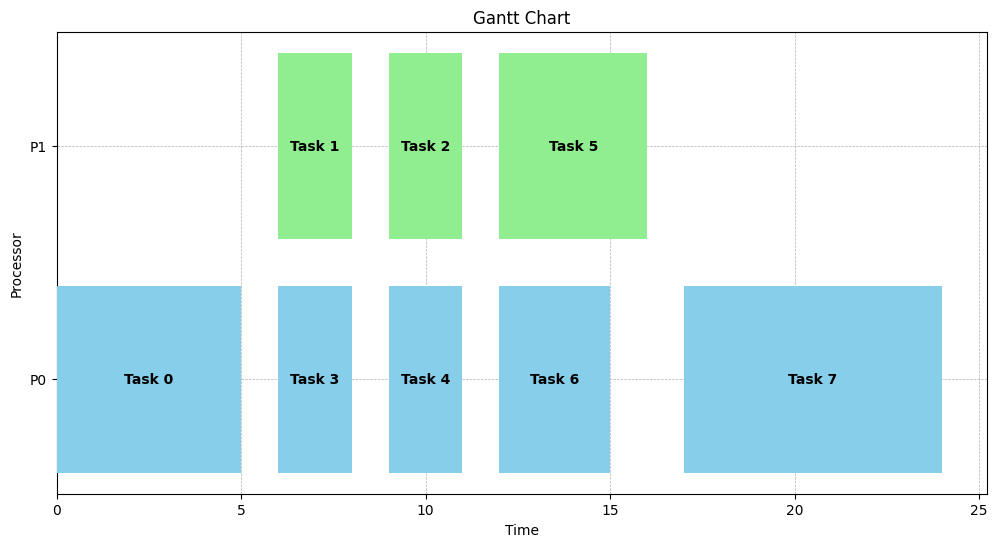

In [51]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create a color map for processors
colors = {'P0': 'skyblue', 'P1': 'lightgreen', 'P2': 'salmon'}

# Plot the Gantt chart
for idx, task in df_gantt.iterrows():
    ax.barh(task['processor'], task['duration'], left=task['start'], color=colors[task['processor']], zorder=3)

# Add task labels inside the bars
for idx, task in df_gantt.iterrows():
    ax.text(task['start'] + task['duration']/2, task['processor'], task['name'],
            va='center', ha='center', color='black', fontweight='bold', zorder=4)

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Processor')
ax.set_title('Gantt Chart')

# Set grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)

plt.show()

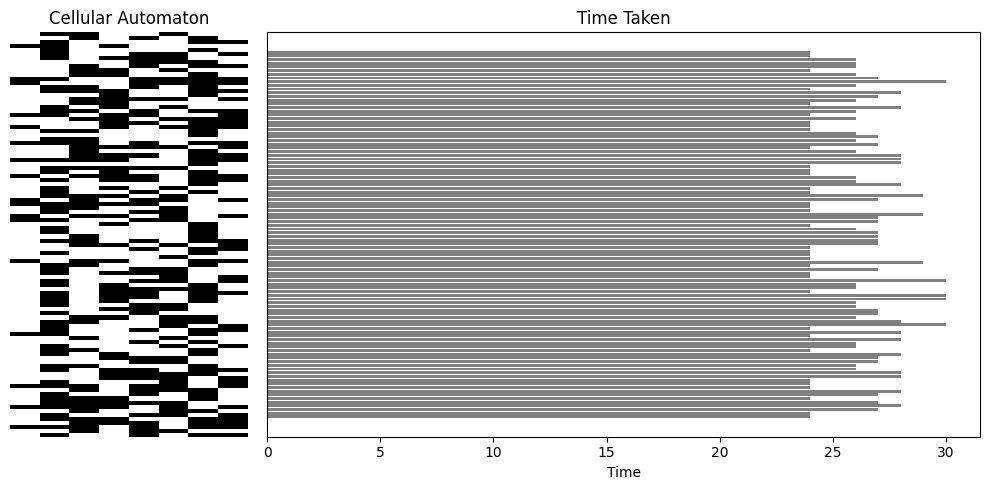

In [52]:
cells = 100  # Number of cells and generations
# Generating corresponding 'time taken' data
times = [lp.evaluate_fitness(x) for x in lp.best_hystory]

# Creating the plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 3]})

# Plot for the automaton
axs[0].imshow(lp.best_hystory, cmap='Greys', aspect='auto')
axs[0].set_title("Cellular Automaton")
axs[0].axis('off')

# Plot for the horizontal bar plot
axs[1].barh(range(cells), times, color='gray')
axs[1].set_title("Time Taken")
axs[1].set_xlabel("Time")
axs[1].set_yticks([])  # Hide y-ticks for cleaner look

plt.tight_layout()
plt.show()

# Log the Data

In [54]:
# Function to generate a hash identifier for the execution based on the date and time
def generate_hash() -> str:
    """
    Generate a hash identifier for the execution based on the date and time.

    Returns:
        str: The hash identifier.
    """
    return hashlib.md5(str(datetime.now()).encode()).hexdigest()

generate_hash()

'3341a2173eda3e09ca624d589a48c46e'

In [55]:
# Apply the generated hash to create a new column 'hash' in df_gantt
df_gantt['hash'] = generate_hash()
df_gantt['total_time'] = df_gantt['end'].max()
df_gantt

,name,processor,start,duration,end,hash,total_time
0,Task 0,P0,0,5,5,16f94b521975ce8132a693ae3e1c67ef,24
1,Task 1,P1,6,2,8,16f94b521975ce8132a693ae3e1c67ef,24
2,Task 2,P1,9,2,11,16f94b521975ce8132a693ae3e1c67ef,24
3,Task 3,P0,6,2,8,16f94b521975ce8132a693ae3e1c67ef,24
4,Task 4,P0,9,2,11,16f94b521975ce8132a693ae3e1c67ef,24
5,Task 5,P1,12,4,16,16f94b521975ce8132a693ae3e1c67ef,24
6,Task 6,P0,12,3,15,16f94b521975ce8132a693ae3e1c67ef,24
7,Task 7,P0,17,7,24,16f94b521975ce8132a693ae3e1c67ef,24


In [56]:
# Let's create a logic to log the df_gantt data to a csv file. must check if the file exists, if not, create it, if it exists, append the data to the file.

directory = './data/'

# Function to log the Gantt chart data to a CSV file
def log_gantt_data(df:pd.DataFrame) -> None:
    """
    Log the Gantt chart data to a CSV file.

    Args:
        df (pd.DataFrame): The Gantt chart data.
    """
    try:
        # Open the file in append mode
        with open(directory+'executions.csv', 'a') as f:
            # Write the data to the file
            df.to_csv(f, header=f.tell()==0, index=False)
    except Exception as e:
        print(f"An error occurred: {e}")

# log_gantt_data(df_gantt)